In [33]:
## This is a Fake News Classifier that is trained on the Kaggle dataset (https://www.kaggle.com/c/fake-news/data#)
## The dataset was choosen for the reason of having the authors name to see if the author_name feature will improve
## the accuracy score. 
## I have also chosen the data to practice preparing text data with nltk, as well as to practice tunning of the 
## RandomForestClassifier and XGBoostClassifier. 
## Label Key : 1 = unreliable & 0 = reliable

## First Import pandas library for data manipulation and query
import pandas as pd
train = pd.read_csv('/home/kyle/Projects/Fake_News/train.csv', index_col = 'id')

In [36]:
## View the first five rows of the dataframe, See columns "title", "author", "text", "label"
train.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
## See which columns are missing data points 
train.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
## To gain a better understanding of the data, lets see what the label indication is when the text column is null
train[train['text'].isna()].label

id
142      1
573      1
1200     1
1911     1
2148     1
2169     1
2793     1
3329     1
3729     1
4288     1
4358     1
5717     1
6215     1
6680     1
8649     1
8908     1
8922     1
9350     1
9446     1
9454     1
9524     1
10466    1
10867    1
11450    1
11486    1
12056    1
12460    1
12835    1
13020    1
13107    1
13915    1
14499    1
14933    1
16126    1
18479    1
18757    1
19157    1
19227    1
19388    1
Name: label, dtype: int64

In [6]:
## It appears that when the text column is null the article immediately returns that the document is unreliable
## Lets see how times the label indication is 1 when the author column is null. 
train[train['author'].isna() & train['label'] == 1].label.sum()

1931

In [17]:
## 1957 is the total number of missing entires for author and 1931 of them have a label indication of 1. 
## Next lets see how many entires have both the text and author value missing. 
len(train[train['author'].isna() & train['text'].isna()].index)

39

In [28]:
## Every row that has the text missing also has the author name therefore those entires mean nothing lets get rid
## Lests get rid of them. 
train = train[train['text'].notna()]

In [31]:
train['text'].isna().sum()

0

In [37]:
## Lets fill in the rest of the null values with 0 to capture them being missing
train = train.fillna(0)

In [39]:
## Lets make a copy of the training dataframe so that we have something to serve as a backup incase we want to 
## restore our previous adjustments up to when we filled the missing values. 
df = train.copy()

In [40]:
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [41]:
## Lets pick the features that we are wanting to keep for the fitting of the model. 
## The two columns that are going to make as our independent or X values are "text" & "author"
## The dependent or Y value is going to be the "label" column. 
## That leaves the title column
df = df.drop('title', axis = 1)

In [42]:
df.head()

,author,text,label
id,,,
0,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [43]:
## Now that we have our dataset with features lets vectorize the features so that our machine learning algorithm 
## can interpert the words that are being read.

## There are many ways to vectorize your data through packages such as LabelEncoder, CountVectorizer,
## and tfidfVectorizer to name a few. I will be using two of these packages to give our data computational meaning. 
## These packages are LabelEncoder, and tfidfVectorizer. 

## LabelEcoder is going to be used to turn the author's name to number so that each name has a specific number that
## will correspond to that name.

## tfidfVectorizer stands for term frequency, inverse document frequency. The way it works is by calculating the 
## term frequency and then multiplying it to the inverse document frequency. The product being a real number 
## between 0 and 1.

## Lets satrt with initalizing a function to calculate the tfidfVectors. To do so we are going to need to do some 
## preprocessing. This is removing all punctuation, symbols, or unique lettering that is not represneted in the 
## alphabet. We are going to then stem each word that is in nltk's english stopwords list. What this does is 
## breaksdown the word so that the word can be matched with words that at the root are the same. An example:
## help and Helping convert to --> help. 

## Lets start by importing the neccesary packages
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfvect(df):
    corpus = [] ## List to add all words after preprocessing
    stemmer = PorterStemmer() ## Our stemmer saved 
    for i in range(0, len(df)): ## for loop running from 0 - 2761 
        text = re.sub('[^a-zA-Z]', ' ', str(df['text'][i])).lower().split() ## Getting rid of punctuation, uppercase letters, symbols, and new lines
        text = [stemmer.stem(word) for word in text if not word in stopwords.words('english')] ## Stemming words not in stopwords list
        text = ' '.join(text) ## Join each word to one line instead of array.
        corpus.append(text) ## append the line of processed text to list
        
    tfidfv = TfidfVectorizer(max_features = 10000, ngram_range=(1, 3)) ## run list through tfidfVectorizer, extract 10,000 most used words
    X = tfidfv.fit_transform(corpus).toarray() ## transform the list to an array of vectors
    return X

In [55]:
## Lets import the LabelEncoder package from sklearn
from sklearn.preprocessing import LabelEncoder

def labelencode(col): ## Function that takes a column as a input
    name = []
    le = LabelEncoder()
    for i in range(0, len(col)):
        auth = re.sub('[^a-zA-Z]', ' ', str(col[i])).lower().split()
        auth = ' '.join(auth)
        name.append(auth)
    le.fit(name)
    X = le.transform(name)
    return X

In [45]:
## Lets call the functions to get the results
## First the tfidfVectorizer
X = pd.DataFrame(tfidfvect(df)) ## transforming the array to a dataframe to add the author name column

In [46]:
## View
X.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
## Label Encoder
authors = df['author']       
encode_auth = labelencode(authors)
X['author'] = encode_auth

In [51]:
## Finally initialize the dependent variable y
y = df['label']

In [57]:
## An important process of any machine learning model is the testing of the model on a slice of your training data. 
## This can be done with the package train_test_split
## We will be splitting our data into four slices 1. X_train, 2. X_test, 3. y_train, 4. y_test

## import neccesary package
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1) ## Load our dataframe X and our series y to be split where our training size is 67% and testing size is 33% initializing random_state = 1

In [58]:
## The fun part has arrived and we will be looking at two different models to predict our classification of reliable
## and unreliable. The two models are RandomForestClassifier and XGBoostClasifier. 

## Both models make use of trees to form the prediction. Just in two different ways. We wont be growing the through 
## how each one works, it will take too long instead we will name the core characteristics of each. 

## RandomForestClassifier makes uses of decision tree ensembles (a collection of large or small decision trees).
## XGBoostClassifier uses a technique called gradient boosting which relies on the intuition that the best 
## possible next model, when combined with previous models, minimizes the overall prediction error. The key idea 
## is to set the target outcomes for this next model in order to minimize the error. 

## Lets first look at the XGBoostClassifier
"""
    ---------
    
        Note: These models have already been tuned to produce the most significant results, tuning needs to be done
            to discover which parameters are the best with this model and data combination. 
            
    ---------    
"""
## import the packages
from xgboost import XGBClassifier

model_XGBoost = XGBClassifier(n_estimators = 1000, learning_rate = 0.05, n_jobs = 4)
model_XGBoost.fit(X_train, y_train, early_stopping_rounds = 5, eval_set = [(X_test, y_test)], verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
## Now lets fit the RandomForestClasifier
## import packages
from sklearn.ensemble import RandomForestClassifier

model_RFC = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy')
model_RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
## Last step is calculate the accuracy of the model and plot a confusion matrix to analyze the results. 
## function for confusion matrix from scikit-learn website. 
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
## Get predictions and accuracy score for XGBoost 
from sklearn import metrics

pred_XGBoost = model_XGBoost.predict(X_test)
score_XGBoost = metrics.accuracy_score(y_test, pred_XGBoost)
print('Accuracy for XGBoostClassifier: %0.3f' % score_XGBoost)

## Get prediction and accuracy for RandomForestClassifier
pred_RFC = model_RFC.predict(X_test)
score_RFC = metrics.accuracy_score(y_test, pred_RFC)
print('Accuracy for RandomForestClassifier: %0.3f' % score_RFC)

Accuracy for XGBoostClassifier: 0.954
Accuracy for RandomForestClassifier: 0.952


In [70]:
## We are going to repeat the process after removing the author column
X = X.drop('author', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

In [71]:
## This will be for both Models

## XGBoost
model_XGBoost_no_author_ = XGBClassifier(n_estimators = 1000, learning_rate = 0.05, n_jobs = 4)
model_XGBoost_no_author_.fit(X_train, y_train, early_stopping_rounds = 5, eval_set = [(X_test, y_test)], verbose = False)
pred_XGBoost_no_author = model_XGBoost_no_author_.predict(X_test)
score_XGBoost_no_author = metrics.accuracy_score(y_test, pred_XGBoost_no_author)
print('Accuracy for XGBoostClassifier: %0.3f' % score_XGBoost_no_author)

## RandomForest
model_RFC_no_author = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy')
model_RFC_no_author.fit(X_train, y_train)
pred_RFC_no_author = model_RFC_no_author.predict(X_test)
score_RFC_no_author = metrics.accuracy_score(y_test, pred_RFC_no_author)
print('Accuracy for RandomForestClassifier: %0.3f' % score_RFC_no_author)

Accuracy for XGBoostClassifier: 0.949
Accuracy for RandomForestClassifier: 0.948


In [ ]:
## Before looking at how the models have done we can see that removing the author variable made the accuracy score 
## down therefore we can say that it added slim but positive results. Overall the XGBoostClassifier out performed 
## the RandomForestClassifier by 0.2 of a percent. 

Confusion matrix, without normalization


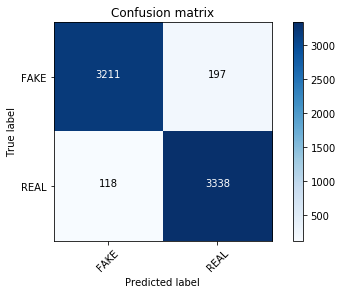

In [72]:
## Confusion Matrix XGBoost

cm = metrics.confusion_matrix(y_test, pred_XGBoost)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Confusion matrix, without normalization


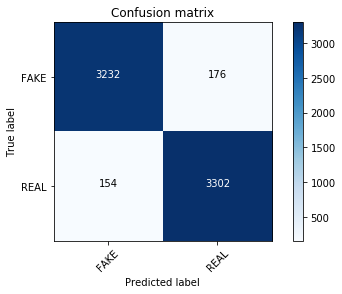

In [73]:
## Confusion Matrix RandomForestClassifier

cm = metrics.confusion_matrix(y_test, pred_RFC)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [75]:
## Next we are going to pickle the XGBoost model for it to be used in Fast API. To eventually be deployed 
## with Docker. 
import pickle

pickle.dump(model_XGBoost, open('model.pkl', 'wb'))